# ONC API 2.0 Usage
Python API usage

[`https://wiki.oceannetworks.ca/display/O2A/Python+Client+Library`](https://wiki.oceannetworks.ca/display/O2A/Python+Client+Library)

Timeseries parameters

[`https://wiki.oceannetworks.ca/display/DP/1`](https://wiki.oceannetworks.ca/display/DP/1)

ADCP parameters

[`https://wiki.oceannetworks.ca/display/DP/5`](https://wiki.oceannetworks.ca/display/DP/5)

***

### Installation

`$ pip install onc`

***

### Import libraries

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import datetime
import subprocess
import warnings
from dateutil.parser import parse
from cmocean import cm
from mpl_toolkits.basemap import Basemap

# ONC library
from onc.onc import ONC

%matplotlib inline
plt.rcParams['font.size'] = 12
warnings.simplefilter('ignore')

***

## Basic usage

Invoke ONC using token

In [3]:
onc = ONC('your-token-here')

***

### Browsing data and locations

**`onc.getLocations()`**

In [4]:
# Print all locations with ADCP150KHZ data
for location in onc.getLocations({'deviceCategoryCode': 'ADCP150KHZ'}):
    print(location['locationCode'], location['locationName'])

BACME MidEast
BACMW MidWest
RVSKQ R/V Sikuliaq
SCVIP Strait of Georgia VENUS Instrument Platform
SEVIP Strait of Georgia East VENUS Instrument Platform
VEC CCGS Vector


**`onc.getDeviceCategories()`**

In [5]:
# Print all devices at ONC Central Node
for device in onc.getDeviceCategories({'locationCode': 'SCVIP'}):
    print(device['deviceCategoryCode'])

ADCP150KHZ
ADCP600KHZ
CTD
CURRENTMETER
ECHOSOUNDERBIOA
FLNTU
HYDROPHONE
JB
OXYSENSOR
PARTANALYZER
TURBIDITYMETER
VIDEOCAM


**`onc.getDataProducts()`**

In [6]:
# Print all data products at ONC Central Node
for dataproduct in onc.getDataProducts({'locationCode': 'SCVIP', 'extension': 'nc'}):
    print(dataproduct['dataProductCode'], dataproduct['dataProductName'])

CSPPD Cast Scalar Profile Plot and Data
RADCPTS RDI ADCP Time Series
TSSD Time Series Scalar Data
TSSPPGD Time Series Scalar Profile Plot and Gridded Data


***

### Downloading data

**`onc.orderDataProduct()`**

ADCP example. Filters will be different for e.g., CTD.

In [7]:
# Filters for ONC Central Node ADCP data
# dpo parameters from https://wiki.oceannetworks.ca/display/DP/5
filters = {
    'locationCode': 'SCVIP',
    'deviceCategoryCode': 'ADCP150KHZ',
    'dataProductCode': 'RADCPTS',
    'extension': 'nc',
    'dateFrom': '2019-01-01T00:00:00.000Z',
    'dateTo': '2019-01-02T00:00:00.000Z',
    'dpo_ensemblePeriod': 900,    # Default value
    'dpo_velocityBinmapping': 2,  # Default value
    'dpo_3beam': 'Off',           # Default value
    'dpo_corScreen': 64,          # Default value
    'dpo_errVelScreen': 2,        # Default value
    'dpo_falseTarScreen': 255,    # Default value
}

# Obtain download handle
# -- set downloadResultsOnly=True to prevent full download, use url instead
# -- may time out if maxRetries is too low
downloadHandle = onc.orderDataProduct(filters=filters, maxRetries=100, downloadResultsOnly=True)

Request Id: 3117123
Estimated File Size: No estimated file size available.
  Running...
  Running... working on time range 1 of 1, for device deployment 1 of 1.....................................................
  download URL: http://data.oceannetworks.ca/api/dataProductDelivery?method=download&token=76fc91e5-d4a4-40f9-87fc-2f6d2707fc5a&dpRunId=8053169&index=1
  'Metadata file not valid for data product' for index - value: 'meta'
  0 files (72.1 KB) downloaded
Actual Processing/Download Time: 0:2:4.68


In [8]:
# List download handle parameters
for item in downloadHandle['downloadResults'][0].items():
    print(item[0] + ':', item[1])

url: http://data.oceannetworks.ca/api/dataProductDelivery?method=download&token=76fc91e5-d4a4-40f9-87fc-2f6d2707fc5a&dpRunId=8053169&index=1
message: ['Running', 'Running... working on time range 1 of 1, for device deployment 1 of 1.']
queuingTime: 0
runningTime: 122.292669
transferringTime: 0
downloadingTime: 0
requestCount: 58
status: complete
size: 73828.0
file: c:/temp/Central_StraitofGeorgiaVENUSInstrumentPlatform_ADCP150kHz_20190101T000000Z_20190102T000000Z-Ensemble900s_binMapLinearInterp.nc
index: 1
downloaded: False


**`onc.downloadFile()`**

So far this only works for me if the path is in an as-of-yet non-existent directory (e.g., `ONC/temp`)

In [10]:
# Download data from URL to filepath
filepath = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/ONC/temp/ADCP_test.nc'
downloadResult = onc.downloadFile(downloadHandle['downloadResults'][0]['url'], filepath)

In [11]:
# Print download parameters
for item in downloadResult.items():
    print(item[0] + ':', item[1])

url: http://data.oceannetworks.ca/api/dataProductDelivery?method=download&token=76fc91e5-d4a4-40f9-87fc-2f6d2707fc5a&dpRunId=8053169&index=1
file: /ocean/bmoorema/research/MEOPAR/analysis-ben/data/ONC/temp/ADCP_test.nc
message: []
size: 73828.0
downloaded: True
downloadingTime: 0.129569


***

## Some Browsing Examples

Here I look for locations with device categories that I'm interested in, and plot them on a map. This first function plots a map of the Salish Sea using Basemap

In [12]:
def plot_map(ax, lons, lats):
    """Plot a map of the Salish Sea ONC region given lons and lats as bounds
    """

    # Make projection
    m = Basemap(
        ax=ax, projection='lcc', resolution='h',
        lon_0=(int(np.diff(lons))) / 2 + lons[0],
        lat_0=(int(np.diff(lats))) / 2 + lats[0],
        llcrnrlon=lons[0], urcrnrlon=lons[1],
        llcrnrlat=lats[0], urcrnrlat=lats[1],
    )
    
    # Add features and labels
    m.drawcoastlines()
    m.fillcontinents(color='Burlywood')
    m.drawmeridians(np.arange(*np.floor([lons[0], lons[1] + 1])), labels=[0, 0, 0, 1], color='k')
    m.drawparallels(np.arange(*np.floor([lats[0], lats[1] + 1])), labels=[1, 0, 0, 0], color='k')
    m.drawrivers()
    
    return m

This next function calls the map function and overlays the device locations using: `onc.getLocations()`

In [13]:
def plot_device_locations(devices):
    """Plot locations of two lists of specified devices on a map
    """

    # Make figure
    fig, axs = plt.subplots(1, 2, figsize=(17, 10))
    ms = [plot_map(ax, [-126, -122], [48, 51]) for ax in axs]

    # Loop through devices
    for ax, m, devices in zip(axs, ms, devices):
        for device, color in zip(devices, ['c', 'r', 'y', 'green', 'm', 'k']):
            label = device
            if device is 'RADCPTS':  # Use dataProductCode for ADCP (multiple frequencies)
                key = 'dataProductCode'
            else:
                key = 'deviceCategoryCode'

            # Identify and plot device locations
            for location in onc.getLocations({key: device}):  # Main ONC function call
                if (location['lon'] is not None) and (location['lat'] is not None):
                    ax.plot(
                        *m(location['lon'], location['lat']),
                        'ko', markerfacecolor=color, markersize=8, label=label,
                    )
                    label = None

        # Legend
        ax.legend()
    
    return fig, axs, ms

### Locations with physical data devices

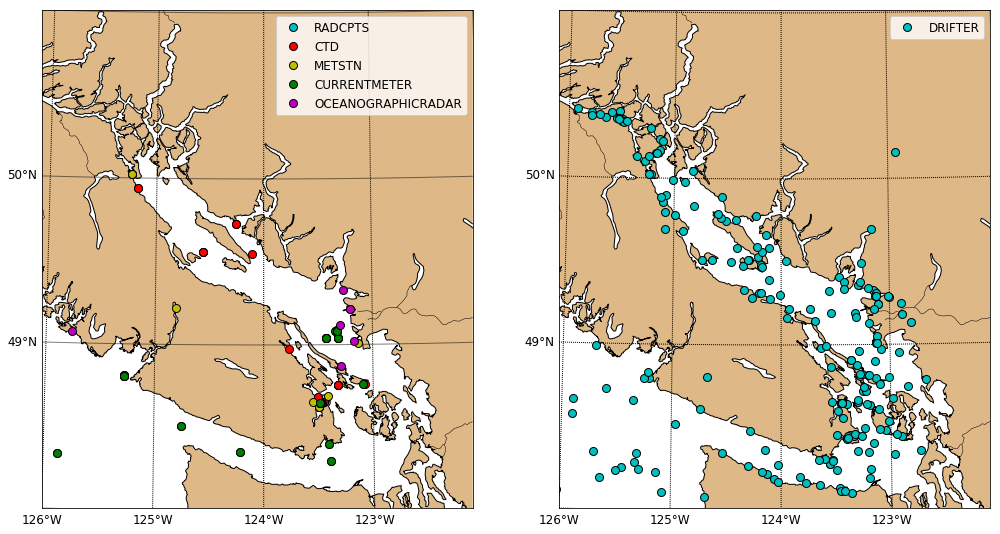

In [14]:
# Plot locations of physical data devices
devices = [
    ['RADCPTS', 'CTD', 'METSTN', 'CURRENTMETER', 'OCEANOGRAPHICRADAR'],
    ['DRIFTER'],
]
fig, axs, ms = plot_device_locations(devices)

### Locations with biological and chemical data devices

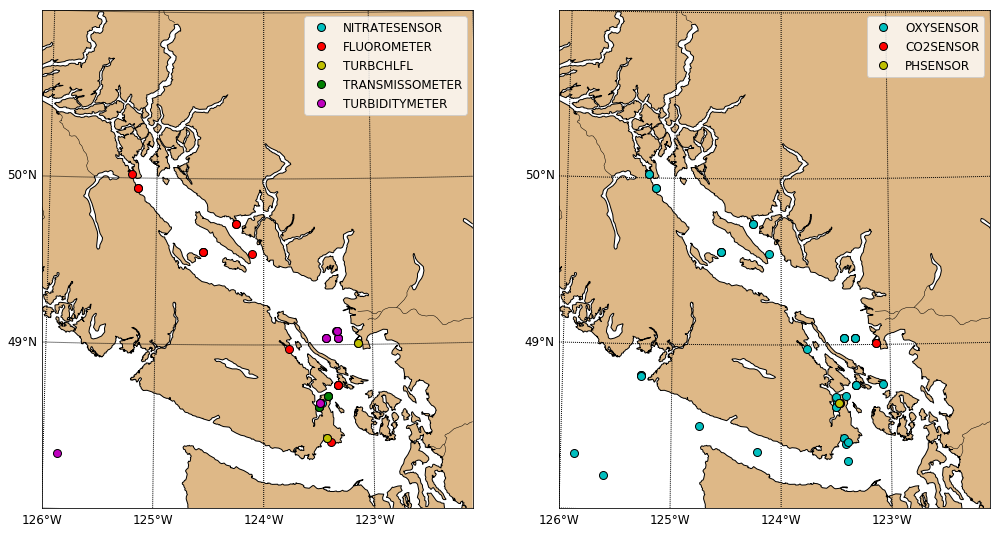

In [15]:
# Plot locations of biological and chemical data devices
devices = [
    ['NITRATESENSOR', 'FLUOROMETER', 'TURBCHLFL', 'TRANSMISSOMETER', 'TURBIDITYMETER'],
    ['OXYSENSOR', 'CO2SENSOR', 'PHSENSOR'],
]
fig, axs, ms = plot_device_locations(devices)

***

## Streamlining the download process

This function is a wrapper around the ONC download routines. Most of the code handles the temporary download directory and the filename.

In [20]:
def download_ONC(filters, path, maxRetries=200):
    """Downloads ONC data to path using the onc.onc.ONC library and returns the complete file path
    """
    
    # Construct filename including simple datestrings
    dates = [parse(filters[key]).strftime('%Y%b%d') for key in ['dateFrom', 'dateTo']]
    filename = '_'.join(
        ['ONC', filters['deviceCategoryCode'], filters['locationCode'], *dates],
    ) + '.' + filters['extension']
    
    # Assign filepath to a temporary directory (couldn't find a way around this)
    filepath = os.path.join(path, 'temp', filename)
    
    # Get download data and URL
    downloadHandle = onc.orderDataProduct(
        filters=filters, maxRetries=maxRetries, downloadResultsOnly=True, includeMetadataFile=False,
    )
    
    # Download data from URL to filepath
    downloadResult = onc.downloadFile(downloadHandle['downloadResults'][0]['url'], filepath)
    
    # Move file and remove temporary directory
    msg = subprocess.call(['mv', filepath, path])
    msg = subprocess.call(['rm', '-r', os.path.join(path, 'temp')])
    
    return os.path.join(path, filename)

***

### Downloading and plotting ADCP data

Define download parameters

In [22]:
# Date range and data path
daterange = ['2018 Jan 1 00:00', '2018 Jan 2 00:00']
path = '/ocean/bmoorema/research/MEOPAR/analysis-ben/data/ONC'

# Filters
# dpo parameters from https://wiki.oceannetworks.ca/display/DP/5
filters = {
    'deviceCategoryCode': 'ADCP150KHZ',
    'dataProductCode': 'RADCPTS',
    'extension': 'nc',
    'dateFrom': parse(daterange[0]).isoformat() + '.000Z',
    'dateTo': parse(daterange[1]).isoformat() + '.000Z',
    'dpo_ensemblePeriod': 900,    # Default value
    'dpo_velocityBinmapping': 2,  # Default value
    'dpo_3beam': 'Off',           # Default value
    'dpo_corScreen': 64,          # Default value
    'dpo_errVelScreen': 2,        # Default value
    'dpo_falseTarScreen': 255,    # Default value
}

ADCP plotting routine

In [23]:
def plot_ADCP(filepath):
    """Plot ADCP data from filepath
    """

    # Load ADCP data
    data = xr.open_dataset(filepath)
    date = data.time.values.astype('datetime64[s]').astype(datetime.datetime)

    # Make figure
    fig, axs = plt.subplots(1, 2, figsize=(17, 10))
    cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])

    # Plot u and v fields
    for ax, vel in zip(axs, ['u', 'v']):
        c = ax.contourf(date, data.depth, data[vel].T, levels=np.arange(-1, 1.1, 0.05), cmap=cm.curl, extend='both')
        ax.set_ylim([290, 20])
        ax.set_title(f'ADCP {vel} velocity at {data.location_name}')

    # Colorbar
    fig.colorbar(c, cax=cax, label='[m/s]')
    plt.show()
    
    return fig, axs

***

### Central node ADCP
Download to netCDF

In [26]:
# Download central node ADCP data as .nc
filters['locationCode'] = 'SCVIP'
filepath = download_ONC(filters, path)

Request Id: 3117126
Estimated File Size: No estimated file size available.
  Running
  Running... working on time range 1 of 1, for device deployment 1 of 1..............................................................................................................................................
  Running...100.00% of deployment 1 of 1 completed.
  download URL: http://data.oceannetworks.ca/api/dataProductDelivery?method=download&token=76fc91e5-d4a4-40f9-87fc-2f6d2707fc5a&dpRunId=8056942&index=1

  Data product complete, running metadata.......  0 files (100.32 KB) downloaded
Actual Processing/Download Time: 0:5:22.28


Load netCDF and plot

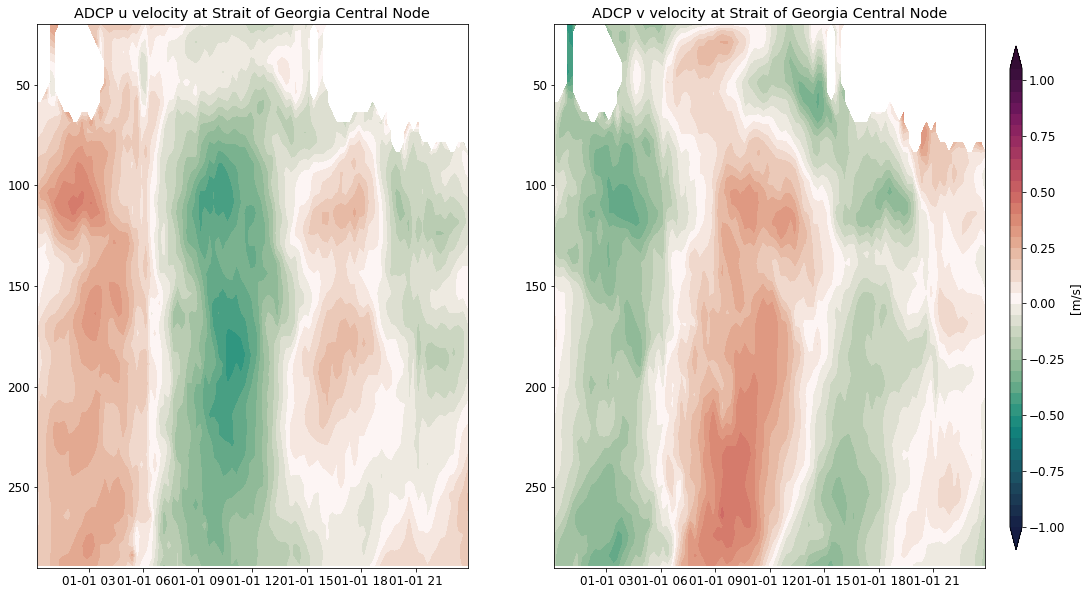

In [27]:
# Plot central node ADCP
fig, axs = plot_ADCP(filepath)

***

### East node ADCP
Download to netCDF

In [28]:
# Download east node ADCP data as .nc
filters['locationCode'] = 'SEVIP'
filepath = download_ONC(filters, path)

Request Id: 3117130
Estimated File Size: No estimated file size available.
  Running..
  Running... working on time range 1 of 1, for device deployment 1 of 1.............................................................................................................
  download URL: http://data.oceannetworks.ca/api/dataProductDelivery?method=download&token=76fc91e5-d4a4-40f9-87fc-2f6d2707fc5a&dpRunId=8056957&index=1
  0 files (100.32 KB) downloaded
Actual Processing/Download Time: 0:3:57.56


Load netCDF and plot

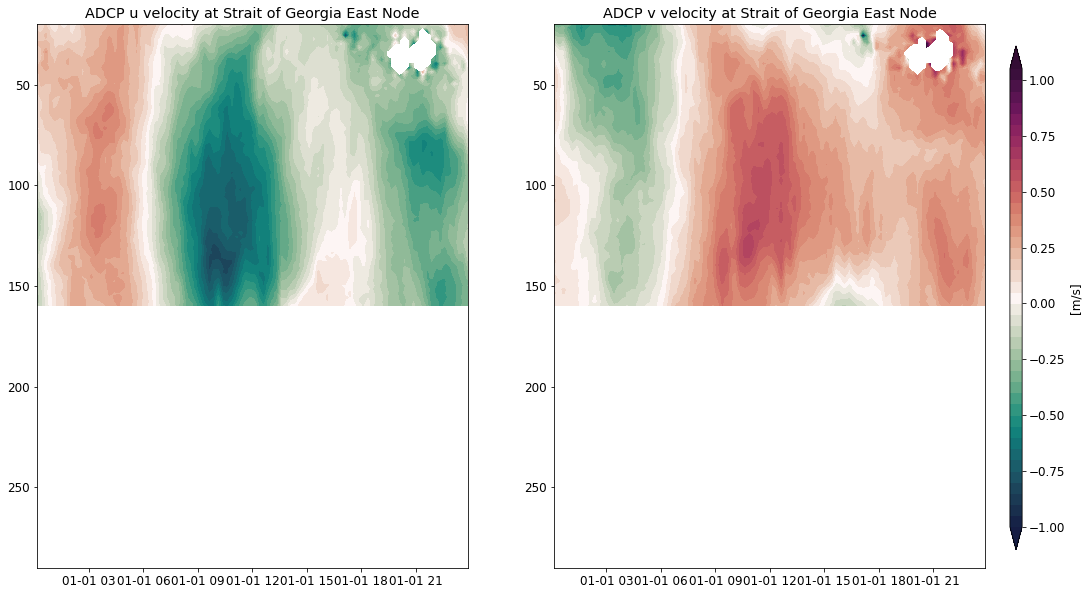

In [29]:
# Plot east node ADCP
fig, axs = plot_ADCP(filepath)